In [45]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from glob import glob
import xesmf as xe
import cmocean
import datetime
import sys
sys.path.append('../')
from utils import fix_crocotime
from numerics import center_crocogrid, rhopoints_depths, filter_timeseries
from load import load_croco

---
### CHECK SPINUP

In [38]:
status = pd.read_csv('data/crocod0_status.out', index_col=1, sep=' ')[::24]
status.index = [pd.Timedelta(days=d)+pd.to_datetime('1949-12-31') for d in status.index]
status

,STEP,KINETIC_ENERGY,POTENTIAL_ENERGY,TOTAL_ENERGY,NET_VOLUME
1999-01-01 00:00:00.000000000,0,0.001388,48.520931,48.522319,8.513361e+140
1999-01-01 01:00:00.287999744,24,0.001412,48.520851,48.522263,8.513361e+140
1999-01-01 01:59:59.712000256,48,0.001414,48.520403,48.521817,8.513361e+140
1999-01-01 03:00:00.000000000,72,0.001413,48.519667,48.521080,8.513361e+140
1999-01-01 04:00:00.287999744,96,0.001412,48.518653,48.520065,8.513359e+140
...,...,...,...,...,...
2011-09-30 19:32:30.335999744,2681749,0.001967,49.237213,49.239180,8.513293e+140
2011-09-30 20:32:29.760000000,2681773,0.001964,49.237873,49.239837,8.513294e+140
2011-09-30 21:32:30.048000000,2681797,0.001961,49.238523,49.240484,8.513295e+140
2011-09-30 22:32:30.335999744,2681821,0.001958,49.239163,49.241122,8.513295e+140


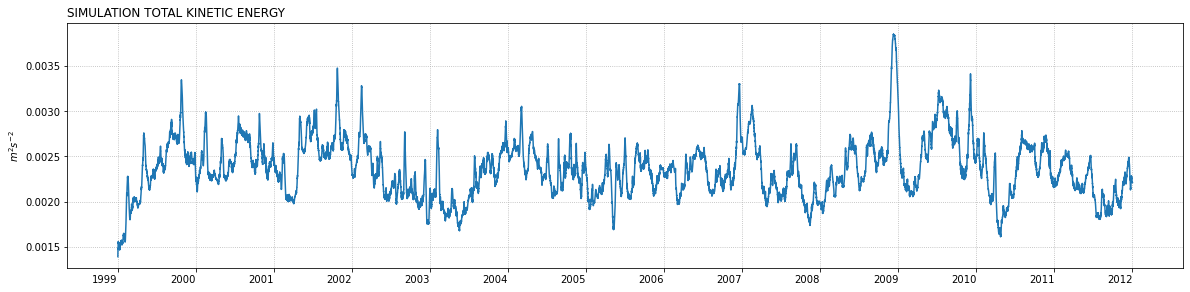

In [54]:
status.KINETIC_ENERGY.plot(figsize=(20,5))
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.grid(True, ls=":")
ax.set_title('SIMULATION TOTAL KINETIC ENERGY', loc='left')
ax.set_ylabel('$m^2s^{-2}$')
ax.tick_params(axis='x', rotation=0)

---

In [5]:
x=xr.open_dataset('/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2001M1.nc')
hc,Cs_r = x.hc.item(),x.Cs_r

In [3]:
path = sorted(glob('/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/*avg*'))[25:]
data = []
for p in path:
    print(p)
    x = xr.open_dataset(p)[['temp','salt']].isel(s_rho=-1)
    x = fix_crocotime(x, YORIG='1950-01-01 00:00:00')
    data.append(x.load())
data = xr.concat(data,'time').sortby('time')
data = data.sel(time=slice("2001","2020"))

sst = data.temp
sst = sst.where(sst>0)

sss = data.salt
sss = sss.where(sss>0)
del data
# z_rho = rhopoints_depths(data.h.expand_dims(dim={'s_rho':data.s_rho}), data.zeta, data.s_rho, Cs_r, hc)
# z_rho = z_rho.transpose('time', 's_rho', 'eta_rho', 'xi_rho')
# data = xr.merge([data, z_rho.to_dataset(name='z_rho')])
# data['time'] = data.time-pd.Timedelta(days=1, minutes=1, seconds=15)

/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2001M10.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2001M11.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2001M12.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2001M2.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2001M3.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2001M4.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2001M5.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2001M6.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2001M7.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2001M8.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2001M9.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2002M1.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2002M10.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y2002M11.nc
/ceaza/lucas/CROCO/DESALADORAS_RUND0/OUTPUT/crocod0_avg_Y

In [10]:
ostia = xr.open_dataset('~/storage/SST_CLIMATOLOGY_OSTIA.nc').analysed_sst
ostia = ostia.sel(lon=slice(-76,-70),lat=slice(-34,-27))

In [44]:
son = (ostia.dayofyear>=244)&(ostia.dayofyear<=334)
djf = (ostia.dayofyear<=365)&(ostia.dayofyear>=335)|((ostia.dayofyear>=1)&(ostia.dayofyear<=59))
mam = (ostia.dayofyear>=60)&(ostia.dayofyear<=151)
jja = (ostia.dayofyear>=152)&(ostia.dayofyear<=243)

In [37]:
ostia_season = [ostia.where(x).mean('dayofyear') for x in [djf, mam, jja, son]]
ostia_season = xr.concat(ostia_season,'season')
ostia_season.coords['season']=['DJF','MAM','JJA','SON']

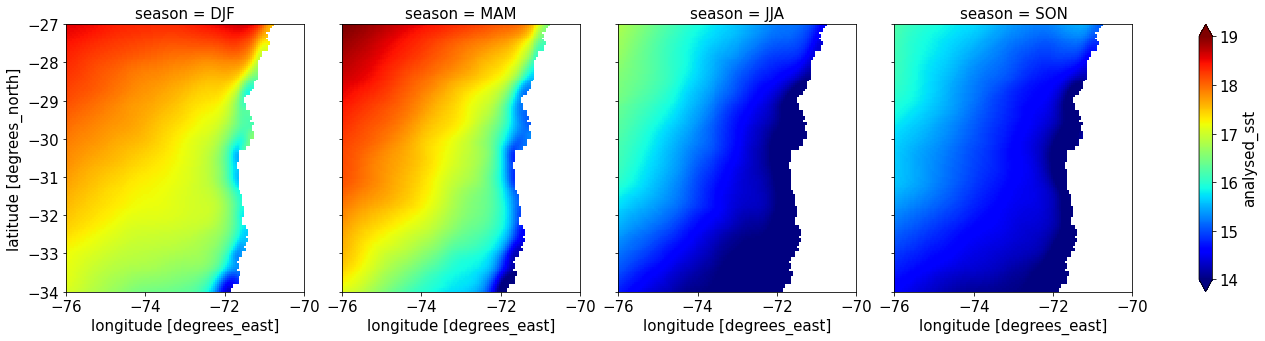

In [45]:
ostia_season.plot(col='season', figsize=(20,5), cmap='jet', vmin=14,vmax=19)

/tmp/ipykernel_9871/2967405455.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(x.get_xticks().astype(int)-360)
/tmp/ipykernel_9871/2967405455.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(x.get_xticks().astype(int)-360)
/tmp/ipykernel_9871/2967405455.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(x.get_xticks().astype(int)-360)
/tmp/ipykernel_9871/2967405455.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(x.get_xticks().astype(int)-360)


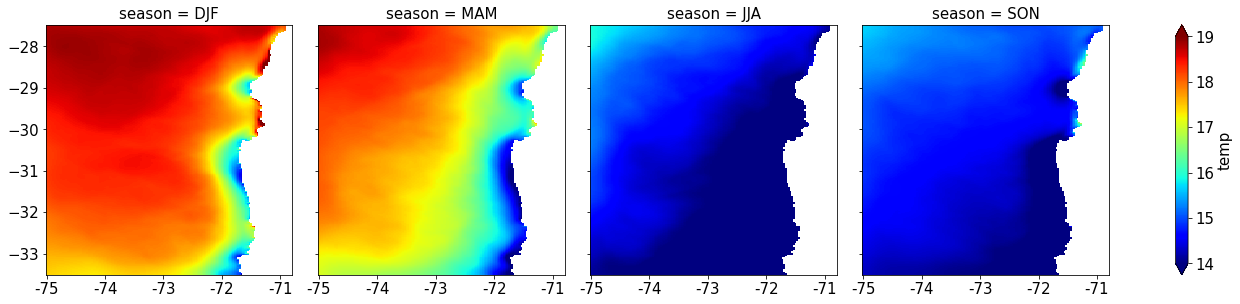

In [42]:
plt.rc('font', size=15)
plot = sst.groupby('time.season').mean().sel(season=['DJF','MAM','JJA','SON']).plot(x='lon_rho',y='lat_rho', col='season', cmap='jet', figsize=(20,5), vmin=14,vmax=19)
ax   = plot.axes
for x in ax.ravel():
    sst[0].where(sst[0]==0).plot(ax=x, x='lon_rho',y='lat_rho', add_colorbar=False, cmap='bone', add_labels=False)
    x.set_ylabel('')
    x.set_xlabel('')
    x.set_xticklabels(x.get_xticks().astype(int)-360)
# sst.groupby('time.season').mean().sel(season=['DJF','MAM','JJA','SON']).plot(x='lon_rho',y='lat_rho', col='season', cmap='jet', figsize=(20,5))

In [78]:
regridder = xe.Regridder(sst.rename({'lat_rho':'lat','lon_rho':'lon'}), ostia, 'bilinear')
bias     = regridder(sst.groupby('time.dayofyear').mean())-ostia

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


/tmp/ipykernel_9871/47921981.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(x.get_xticks().astype(int)-360)
/tmp/ipykernel_9871/47921981.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(x.get_xticks().astype(int)-360)
/tmp/ipykernel_9871/47921981.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(x.get_xticks().astype(int)-360)
/tmp/ipykernel_9871/47921981.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(x.get_xticks().astype(int)-360)


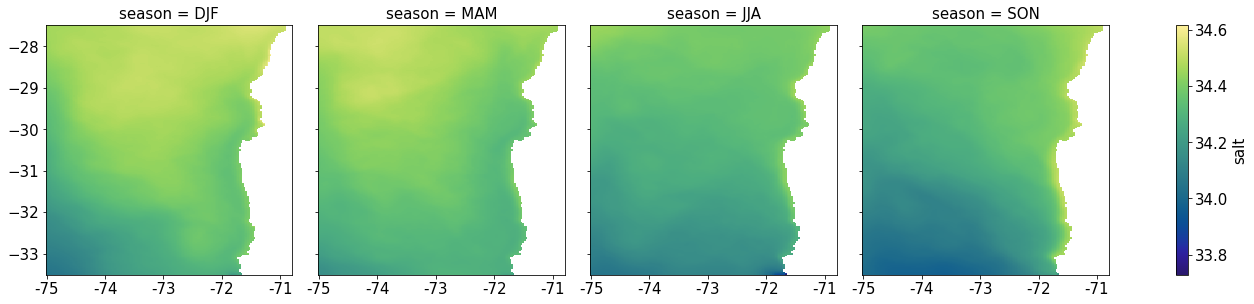

In [17]:
plt.rc('font', size=15)
plot = sss.groupby('time.season').mean().sel(season=['DJF','MAM','JJA','SON']).plot(x='lon_rho',y='lat_rho', col='season', cmap=cmocean.cm.haline, figsize=(20,5))
ax   = plot.axes
for x in ax.ravel():
    sss[0].where(sss[0]==0).plot(ax=x, x='lon_rho',y='lat_rho', add_colorbar=False, cmap='bone', add_labels=False)
    x.set_ylabel('')
    x.set_xlabel('')
    x.set_xticklabels(x.get_xticks().astype(int)-360)
# sst.groupby('time.season').mean().sel(season=['DJF','MAM','JJA','SON']).plot(x='lon_rho',y='lat_rho', col='season', cmap='jet', figsize=(20,5))